# Generative Adversarial Networks (GANs) con CelebA Dataset
## Laboratorio 6 - Data Science Sección 20
~ Samuel Chamale 21885

~ Adrian Rodriguez 21691

In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers # type: ignore


In [2]:
# Constants
DATA_DIR = 'img_align_celeba/img_align_celeba'  # Replace with the path to your CelebA images
# Download from https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/
BATCH_SIZE = 128
IMG_HEIGHT = 64 # According to kaggle dataset
IMG_WIDTH = 64 # According to kaggle dataset
EPOCHS = 30
BUFFER_SIZE = 60000
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
SAVE_DIR = 'gan_images'
checkpoint_dir = './training_checkpoints'
MODEL_SAVE_PATH = 'gan_generator.pkl'

In [3]:
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [4]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [5]:
# Configure TensorFlow to use the GPU and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True to prevent TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU instead.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Preparación de los datos

In [6]:
def load_image(image_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize image to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

In [7]:
image_paths = [os.path.join(DATA_DIR, fname) for fname in os.listdir(DATA_DIR)]
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. Implementación de la GAN

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)
    return model

generator = make_generator_model()

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                                     input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Generator wants discriminator to believe fake images are real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## 3. Entrenamiento de la GAN

In [11]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    plt.savefig(f'{SAVE_DIR}/image_at_epoch_{epoch:04d}.png')
    plt.show()

seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


In [14]:
def train(dataset, epochs, patience=5):
    best_gen_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        start = time.time()
        print(f'\nEpoch {epoch + 1}/{epochs}')

        batch_time = time.time()
        # Initialize tqdm progress bar for batches
        batch_progress = tqdm(dataset, desc='Batches', unit='batch', leave=False)
        batch_count = 0

        for image_batch in batch_progress:
            train_step(image_batch)
            batch_count += 1

            # Update tqdm description with additional info if needed
            batch_progress.set_postfix({'Batch Time': f'{time.time() - batch_time:.2f}s'})
            batch_time = time.time()

        # Evaluate generator loss on a batch of noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator(noise, training=False)
        fake_output = discriminator(generated_images, training=False)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(tf.ones_like(fake_output), fake_output)

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}')
        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

        # Early stopping logic
        if gen_loss < best_gen_loss:
            best_gen_loss = gen_loss
            patience_counter = 0
            # Save the best model weights
            generator.save_weights('best_generator.h5')
            discriminator.save_weights('best_discriminator.h5')
        else:
            patience_counter += 1
            print(f"Patience Counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                # Load the best model weights before stopping
                generator.load_weights('best_generator.h5')
                discriminator.load_weights('best_discriminator.h5')
                return

        # Produce images for visualization
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


Epoch 1/30


Epoch 1, Generator Loss: 1.4377, Discriminator Loss: 0.6542
Time for epoch 1 is 1230.39 sec


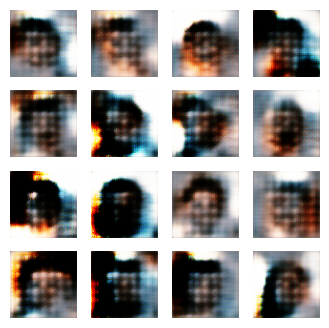


Epoch 2/30


Epoch 2, Generator Loss: 1.4947, Discriminator Loss: 0.6463
Time for epoch 2 is 1604.82 sec
Patience Counter: 1/5


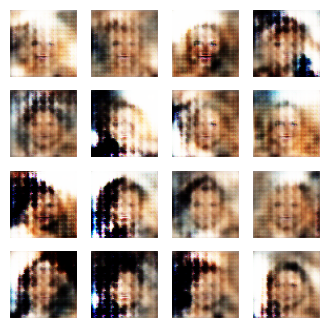


Epoch 3/30


Epoch 3, Generator Loss: 1.3425, Discriminator Loss: 0.6698
Time for epoch 3 is 1530.61 sec


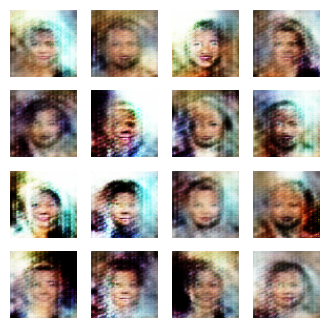


Epoch 4/30


Epoch 4, Generator Loss: 2.2213, Discriminator Loss: 0.5251
Time for epoch 4 is 1534.60 sec
Patience Counter: 1/5


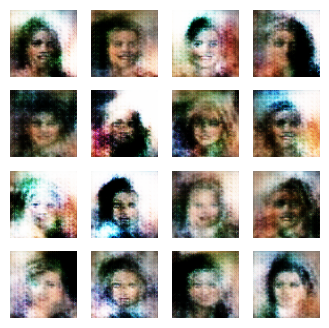


Epoch 5/30


Epoch 5, Generator Loss: 2.3549, Discriminator Loss: 0.4617
Time for epoch 5 is 1534.69 sec
Patience Counter: 2/5


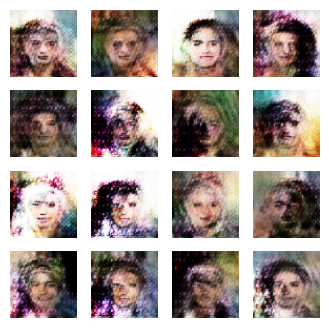


Epoch 6/30


Epoch 6, Generator Loss: 1.7322, Discriminator Loss: 0.5746
Time for epoch 6 is 1524.70 sec
Patience Counter: 3/5


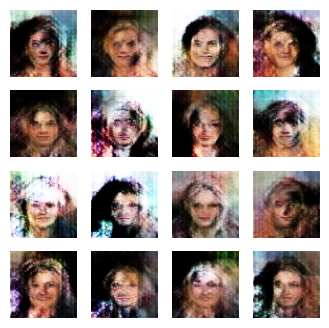


Epoch 7/30


Epoch 7, Generator Loss: 2.0186, Discriminator Loss: 0.5345
Time for epoch 7 is 1527.75 sec
Patience Counter: 4/5


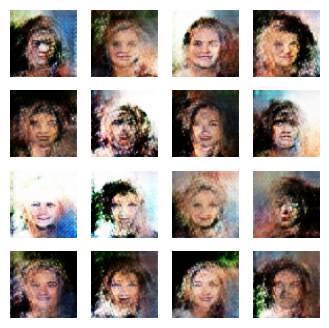


Epoch 8/30


Epoch 8, Generator Loss: 3.3526, Discriminator Loss: 0.3826
Time for epoch 8 is 1527.57 sec
Patience Counter: 5/5
Early stopping triggered.


In [15]:
train(dataset, EPOCHS)

In [16]:
# Save the generator model to a pickle file
with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(generator.get_weights(), f)

In [17]:
# Load the generator model from the pickle file
with open(MODEL_SAVE_PATH, 'rb') as f:
    weights = pickle.load(f)

generator = make_generator_model()
generator.set_weights(weights)

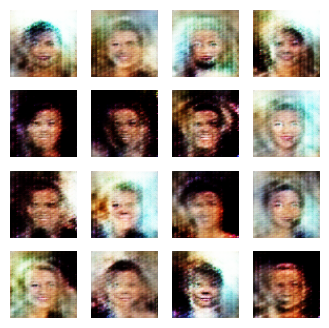

In [18]:
# Generate images using the trained generator
noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    img = (generated_images[i] * 127.5 + 127.5).numpy().astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
plt.show()